In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# GET MNIST DATASET

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define a transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

# Download and load the training dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

# Download and load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.16MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 193kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.17MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.91MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train dataset size: 60000
Test dataset size: 10000


# DataLoaders

In [9]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, persistent_workers=True)

# Verify dataset size
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



for batch in train_dataloader:
    images, labels = batch
    print(f"Image batch dimensions: {images.shape}")
    print(f"Image label dimensions: {labels}")
    break

Train dataset size: 60000
Test dataset size: 10000
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: tensor([6, 7, 2, 6, 1, 1, 7, 6, 9, 3, 8, 9, 2, 7, 6, 8, 5, 8, 9, 1, 7, 7, 7, 3,
        4, 9, 8, 7, 9, 5, 6, 1, 0, 1, 3, 4, 1, 1, 7, 8, 0, 9, 2, 7, 1, 0, 5, 2,
        1, 9, 1, 4, 2, 5, 1, 7, 2, 3, 1, 5, 4, 8, 4, 0])


# Print some sample images

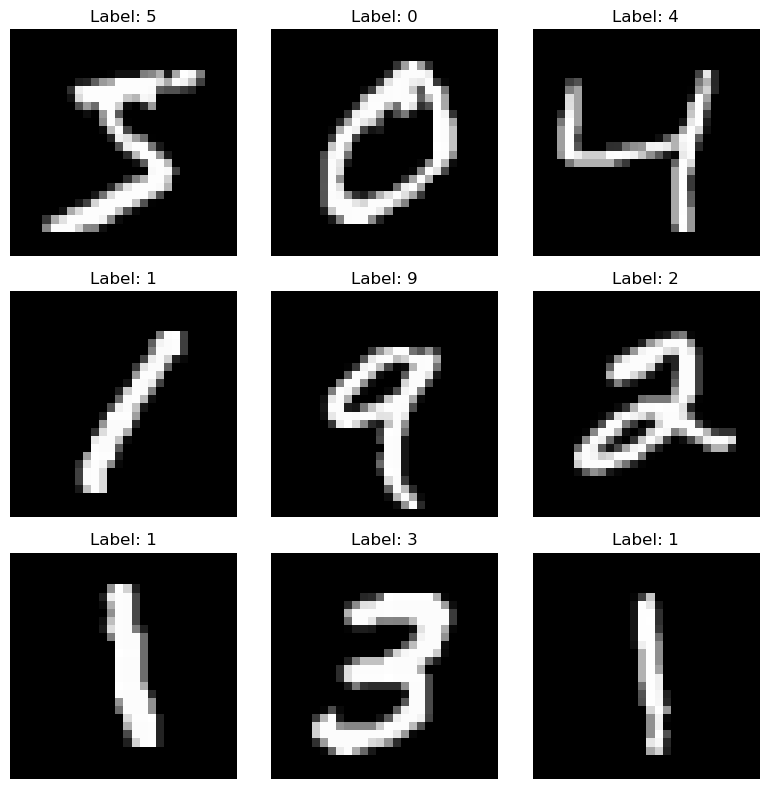

In [6]:
import matplotlib.pyplot as plt

# Plot the first 9 images from the training dataset
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    image, label = train_dataset[i]  # get image and label
    # Since the image is a tensor of shape (1, H, W), use squeeze() to remove the channel dimension.
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torch.nn.functional as F

class MNIST_CNN(pl.LightningModule):
    def __init__(self, config):
        super().__init__()

        # unpack config
        num_classes = config["model"]["num_classes"]
        h = config["model"]["hidden_units"]
        self.lr = config["optimizer"]["learning_rate"]
        self.weight_decay = config["optimizer"]["weight_decay"]

        # Define CNN layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, h)  # After 2 pooling layers, image size is 7x7
        self.fc2 = nn.Linear(h, num_classes)

    def forward(self, x):                   # x.shape = (batch_size, 1, 28, 28)
        x = F.relu(self.conv1(x))           # -> (batch_size, 32, 28, 28)
        x = self.pool(x)                    # -> (batch_size, 32, 14, 14)
        x = F.relu(self.conv2(x))           # -> (batch_size, 64, 14, 14)
        x = self.pool(x)                    # -> (batch_size, 64, 7, 7)
        
        x = torch.flatten(x, start_dim=1)   # -> (batch_size, 64*7*7)
        x = F.relu(self.fc1(x))             # -> (batch_size, h)
        x = self.fc2(x)                     # -> (batch_size, num_classes)   
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)  # Compute loss
        acc = (y_hat.argmax(dim=1) == y).float().mean()  # Compute accuracy

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

# Set device and instantiate the model

In [76]:
# Set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print(device)
# Initialize model
model = MNIST_CNN(config).to(device)
model

mps


MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Test DataLoader and Model 

In [77]:
for batch in train_dataloader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    print(f"Image batch dimensions: {images.shape}")
    print(f"Image label dimensions: {labels}")
    y_pred = model(images)
    print(f"Predictions shape: {y_pred.shape}")
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: tensor([9, 1, 4, 0, 9, 9, 7, 4, 5, 7, 1, 6, 1, 5, 4, 9, 1, 9, 8, 4, 7, 8, 1, 2,
        6, 4, 3, 6, 4, 0, 7, 7, 3, 8, 3, 9, 2, 3, 6, 2, 8, 9, 4, 0, 6, 8, 0, 6,
        0, 5, 0, 9, 5, 2, 4, 2, 1, 0, 2, 5, 8, 2, 4, 7], device='mps:0')
Predictions shape: torch.Size([64, 10])


## Test full pipeline 

In [78]:
trainer = pl.Trainer(
    max_epochs=1,  
    accelerator="mps" if torch.backends.mps.is_available() else "cpu",
    limit_train_batches=0.1,  
    limit_val_batches=0.1
)
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 320    | train
1 | conv2 | Conv2d    | 18.5 K | train
2 | pool  | MaxPool2d | 0      | train
3 | fc1   | Linear    | 401 K  | train
4 | fc2   | Linear    | 1.3 K  | train
--------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 93/93 [00:00<00:00, 113.34it/s, v_num=25, train_loss_step=0.306, val_loss=0.209, val_acc=0.940, train_loss_epoch=0.519]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 93/93 [00:00<00:00, 111.46it/s, v_num=25, train_loss_step=0.306, val_loss=0.209, val_acc=0.940, train_loss_epoch=0.519]


# Load config file

In [ ]:
import yaml

# Load YAML config
with open("mnist_config.yml", "r") as file:
    config = yaml.safe_load(file)

config

{'model': {'num_classes': 10, 'hidden_units': 128},
 'optimizer': {'type': 'adam', 'learning_rate': 0.001, 'weight_decay': 0.0001},
 'trainer': {'max_epochs': 5, 'accelerator': 'mps'},
 'dataset': {'batch_size': 64,
  'num_workers': 2,
  'train_split': 0.8,
  'val_split': 0.2}}

# Training with Lightning

In [81]:
# Train the model using Lightning
trainer = pl.Trainer(max_epochs=5, accelerator="mps" if torch.backends.mps.is_available() else "cpu")
trainer = pl.Trainer(**config["trainer"])
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 320    | train
1 | conv2 | Conv2d    | 18.5 K | train
2 | pool  | MaxPool2d | 0      | train
3 | fc1   | Linear    | 401 K  | train
4 | fc2   | Linear    | 1.3 K  | train
--------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 938/938 [00:07<00:00, 131.06it/s, v_num=26, train_loss_step=0.0027, val_loss=0.0276, val_acc=0.991, train_loss_epoch=0.019]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 938/938 [00:07<00:00, 130.79it/s, v_num=26, train_loss_step=0.0027, val_loss=0.0276, val_acc=0.991, train_loss_epoch=0.019]


# Test Accuracy

In [82]:
trainer.test(model, dataloaders=test_dataloader)

Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 303.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9911999702453613
        test_loss          0.027592942118644714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.027592942118644714, 'test_acc': 0.9911999702453613}]

# Visually inspect predictions

torch.Size([64, 1, 28, 28]) torch.Size([64])
mps


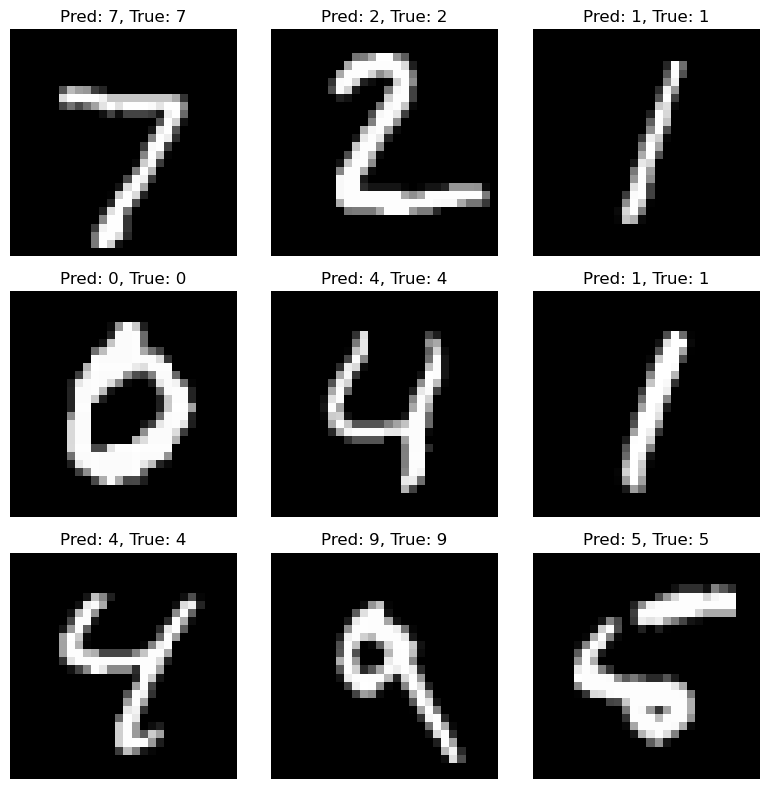

In [83]:
import matplotlib.pyplot as plt

# Get a batch from the test dataset
batch = next(iter(test_dataloader))
x, y = batch
x, y = x.to(device), y.to(device)
print(x.shape, y.shape)
print(device)
# Get model predictions
model.eval()
model.to(device)
with torch.no_grad():
    y_hat = model(x)

# Convert logits to predicted class labels
preds = y_hat.argmax(dim=1)

# Plot first 9 images with predictions
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    img = x[i].cpu().squeeze()  # Remove extra dimension
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {preds[i].item()}, True: {y[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Test and Val loss

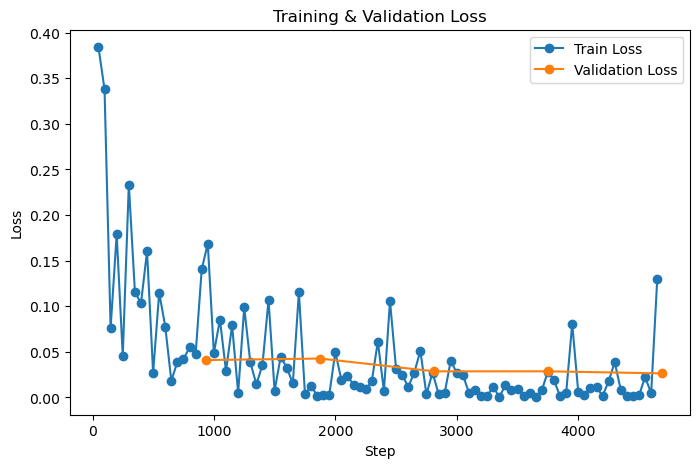

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Load logs from TensorBoard
log_dir = "lightning_logs/version_22"  # Adjust the version number if needed
metrics = pd.read_csv(f"{log_dir}/metrics.csv")

# Filter loss values
train_loss = metrics[metrics['train_loss'].notna()][['step', 'train_loss']]
val_loss = metrics[metrics['val_loss'].notna()][['step', 'val_loss']]

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss['step'], train_loss['train_loss'], label="Train Loss", marker="o")
plt.plot(val_loss['step'], val_loss['val_loss'], label="Validation Loss", marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()